In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# NA
import missingno as msno

# dimensionality reduction 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import minmax_scale

from sklearn.manifold import TSNE
import random

from sklearn.manifold import Isomap

# model part
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.cluster import DBSCAN

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# upsampling
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import ADASYN

import xgboost as xgb
from sklearn.metrics import roc_curve, auc

# data check

In [0]:
data = pd.read_csv('sample_data/creditcard.csv')
data.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


## check the missing value

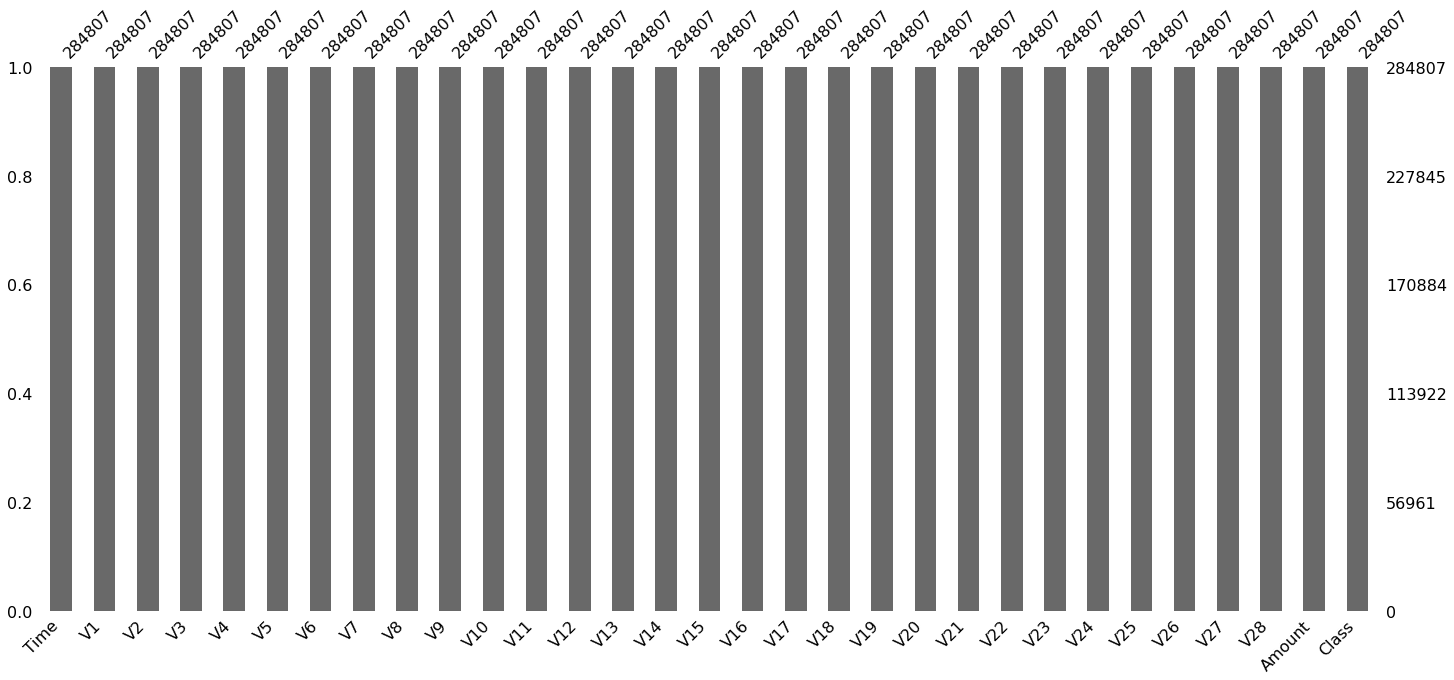

In [0]:
msno.bar(data)

## check the class distribution 

- this is really imbalanced dataset

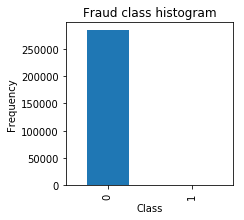

In [0]:
data.Class.value_counts().plot(kind='bar',figsize=(3, 3))
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [0]:
class_dist = list(data.Class.value_counts()/data.shape[0]*100)
print('Percentage of normal transactions: {}%'.format(class_dist[0]))
print('Percentage of fraud transactions: {}'.format(class_dist[1]))

Percentage of normal transactions: 99.82725143693798%
Percentage of fraud transactions: 0.1727485630620034


# feature engineering

## convert the secs to hours for time feature

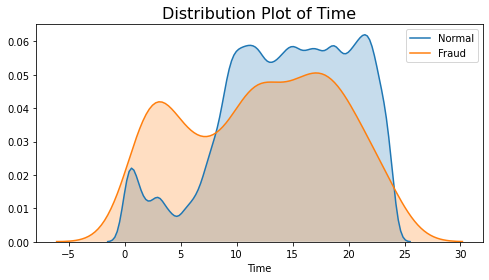

In [0]:
data['Time'] = ( data['Time'].values / 3600 ) % 24

fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(data.loc[data.Class == 0,'Time'], label='Normal', 
             ax=ax, hist=False, kde_kws={"shade": True})
sns.distplot(data.loc[data.Class == 1,'Time'], label='Fraud', 
             ax=ax, hist=False, kde_kws={"shade": True})
ax.set_title('Distribution Plot of Time', fontsize=16)
ax.legend()
plt.show()

# Viz

In [0]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)

In [0]:
X = data.drop('Class', axis=1)
y = data.Class

## PCA

In [0]:
def pca_process(X, y):
    scaler = StandardScaler()   
    norm_X = scaler.fit_transform(X)
    
    
    pca = PCA(n_components=2, random_state=42)
    pca_matrix = pca.fit_transform(norm_X)   

    pca_df = pd.DataFrame(pca_matrix, columns=['PC1', 'PC2'])
    
    pca_df['class'] = y
    
    return pca_df

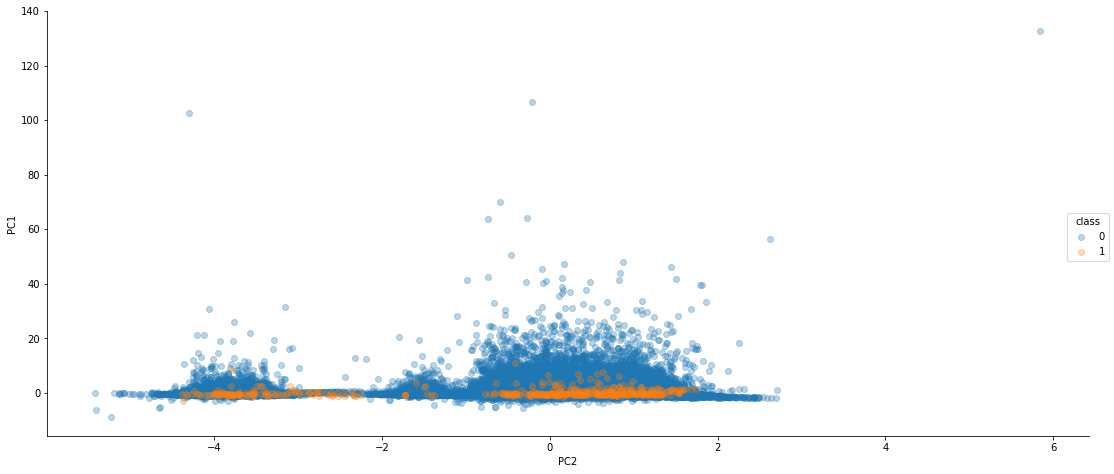

In [0]:
pca_df = pca_process(X, y)

ax = sns.lmplot(data = pca_df, x='PC2', y='PC1', hue='class', size=5, aspect=10, fit_reg=False,
               scatter_kws={'alpha': 0.3})
fig = plt.gcf()
fig.set_size_inches(15, 7)

## LDA

In [0]:
def lda_process(X, y):
    lda = LinearDiscriminantAnalysis(n_components=2)
    
    lda.fit(X, y) 
    lda_X = lda.fit(X, y).transform(X)

    pred = lda.predict(X)
    
    lda_df = pd.DataFrame(lda_X)
    lda_df['class'] = pred
    lda_df.rename(columns={0:'x'},inplace=True)
    
    target_names = ['Normal', 'Fraud']
    confusion_matrix = print(classification_report(y, pred, target_names=target_names))
    
    return lda_df, confusion_matrix

In [0]:
lda_df, confusion_matrix = lda_process(X, y)

/Users/Janice/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(30, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/Users/Janice/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/Users/Janice/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(30, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/Users/Janice/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:472: Fu

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    284315
       Fraud       0.86      0.77      0.81       492

    accuracy                           1.00    284807
   macro avg       0.93      0.88      0.91    284807
weighted avg       1.00      1.00      1.00    284807



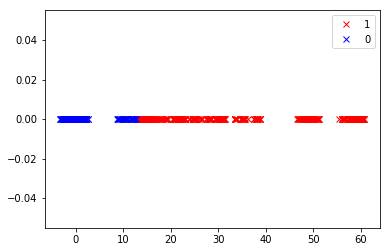

In [0]:
cdict = {1: 'red', 0: 'blue'}

fig, ax = plt.subplots()
for g in cdict.keys():
    plt.plot(lda_df[lda_df['class']==g].x, np.zeros_like(lda_df[lda_df['class']==g].x), 'x' ,c = cdict[g], label = g)
ax.legend()
plt.show()

## T-SNE

In [0]:
sample_data = pd.concat([data[data.Class==1].iloc[:50,:],data.sample(n=500, random_state=42)])
sample_X = sample_data.drop('Class', axis=1)
sample_y = sample_data.Class

tsne_x = TSNE(n_components=2, random_state=42).fit_transform(sample_X)

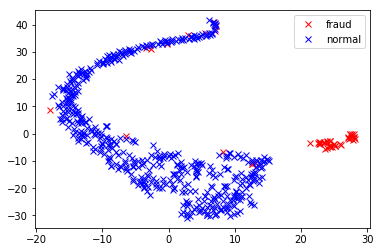

In [0]:
cdict = {1: 'red', 0: 'blue'}
clabel = {1: 'fraud', 0: 'normal'}

fig, ax = plt.subplots()
for g in cdict.keys():
    plt.plot(tsne_x[sample_y==g][:,0], tsne_x[sample_y==g][:,1], 'x' ,c = cdict[g], label = clabel[g])
ax.legend()
plt.show()

## Isomap

In [0]:
isomap_x = Isomap(n_components=2).fit_transform(sample_X)

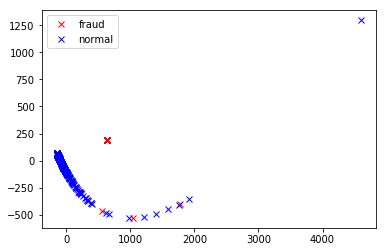

In [0]:
cdict = {1: 'red', 0: 'blue'}
clabel = {1: 'fraud', 0: 'normal'}

fig, ax = plt.subplots()
for g in cdict.keys():
    plt.plot(isomap_x[sample_y==g][:,0], isomap_x[sample_y==g][:,1], 'x' ,c = cdict[g], label = clabel[g])
ax.legend()
plt.show()

# anomaly detection

In [0]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

## DBSCAN

In [0]:
from sklearn.metrics import f1_score

In [0]:
for ep in [2,5,10]:
  for sample in [2,5,10]:
    dbscan = DBSCAN(eps=ep, min_samples=sample)
    dbscan.fit(x_train)

    y_pred_train = dbscan.labels_
    y_pred_train[y_pred_train!=0] = 1

    print('f1 is {}'.format(f1_score(y_train, y_pred_train)),'ep:',ep, 'sample:',sample)

f1 is 0.006581134082297415 ep: 2 sample: 2
f1 is 0.0065806966232384995 ep: 2 sample: 5
f1 is 0.006573705179282868 ep: 2 sample: 10
f1 is 0.26315789473684215 ep: 5 sample: 2
f1 is 0.2535211267605634 ep: 5 sample: 5
f1 is 0.2219482120838471 ep: 5 sample: 10
f1 is 0.4383561643835617 ep: 10 sample: 2
f1 is 0.4324324324324324 ep: 10 sample: 5
f1 is 0.38399999999999995 ep: 10 sample: 10


In [0]:
target_names = ['Normal', 'Fraud']
print(classification_report(y_train, y_pred_train, target_names=target_names))

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     30465
       Fraud       0.26      0.69      0.38        99

    accuracy                           0.99     30564
   macro avg       0.63      0.84      0.69     30564
weighted avg       1.00      0.99      0.99     30564



In [0]:
target_names = ['Normal', 'Fraud']
print(classification_report(y_train, y_pred_train, target_names=target_names))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     30465
       Fraud       0.40      0.48      0.44        99

    accuracy                           1.00     30564
   macro avg       0.70      0.74      0.72     30564
weighted avg       1.00      1.00      1.00     30564



## AutoEncoder

In [0]:
train, test = train_test_split(data, test_size=0.2, random_state=42)
X_train = train[train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = test['Class']
X_test = test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [0]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [0]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [0]:
nb_epoch = 15
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

autoencoder.fit(X_train, X_train,
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose=1,
                callbacks=[checkpointer, tensorboard])

Train on 227451 samples, validate on 56962 samples
Epoch 1/15
227451/227451 [==============================] - 13s 55us/step - loss: 1.0001 - accuracy: 0.6246 - val_loss: 0.8483 - val_accuracy: 0.6761
Epoch 2/15
227451/227451 [==============================] - 12s 52us/step - loss: 0.8511 - accuracy: 0.6819 - val_loss: 0.8093 - val_accuracy: 0.6802
Epoch 3/15
227451/227451 [==============================] - 12s 53us/step - loss: 0.8223 - accuracy: 0.6829 - val_loss: 0.7963 - val_accuracy: 0.6688
Epoch 4/15
227451/227451 [==============================] - 12s 52us/step - loss: 0.8075 - accuracy: 0.6854 - val_loss: 0.7845 - val_accuracy: 0.6834
Epoch 5/15
227451/227451 [==============================] - 12s 54us/step - loss: 0.8000 - accuracy: 0.6855 - val_loss: 0.7762 - val_accuracy: 0.6919
Epoch 6/15
227451/227451 [==============================] - 13s 56us/step - loss: 0.7949 - accuracy: 0.6867 - val_loss: 0.7996 - val_accuracy: 0.6711
Epoch 7/15
227451/227451 [=======================

In [0]:
x_pred_test = autoencoder.predict(X_test)
res = np.sum((x_pred_test-X_test)**2,axis=1)

In [0]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, res)#, pos_label=2)
metrics.auc(fpr, tpr)

0.9601175163368669

# up-sampling and gbm

In [0]:
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time', 'Amount'], axis=1)

X = np.array(data.loc[:, data.columns != 'Class'])
y = np.array(data.loc[:, data.columns == 'Class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [0]:
train_matrix = xgb.DMatrix(X_train, y_train)
test_matrix = xgb.DMatrix(X_test, y_test)

param = {
    'max_depth': 3, 
    'eta': 0.3, 
    'silent': 1,  
    'objective': 'binary:logistic',  
    'eval_metric': 'auc'}  

num_round = 20 

gbm = xgb.train(param, train_matrix, num_round)

In [0]:
# training auc
y_probas = gbm.predict(train_matrix)
fpr, tpr, thresholds = roc_curve(y_train,y_probas) 
auc(fpr, tpr)  

0.9800803520980554

In [0]:
# test auc
y_probas = gbm.predict(test_matrix)
fpr, tpr, thresholds = roc_curve(y_test,y_probas) 
auc(fpr, tpr)   

0.9568934495576509

## SMOTE

In [0]:
sm = SMOTE(random_state = 42)
X_train_sample, y_train_sample = sm.fit_sample(X_train, y_train.ravel())

In [0]:
train_matrix_sample = xgb.DMatrix(X_train_sample, y_train_sample)

param = {
    'max_depth': 3, 
    'eta': 0.3, 
    'silent': 1,  
    'objective': 'binary:logistic',  
    'eval_metric': 'auc'}  

num_round = 20 

gbm = xgb.train(param, train_matrix_sample, num_round)

In [0]:
# training auc
y_probas = gbm.predict(train_matrix)
fpr, tpr, thresholds = roc_curve(y_train,y_probas) 
auc(fpr, tpr)   

0.9972580725851606

In [0]:
# test auc
y_probas = gbm.predict(test_matrix)
fpr, tpr, thresholds = roc_curve(y_test,y_probas)  
auc(fpr, tpr)   

0.9764162605578717

## ADASYN

In [0]:
adasyn = SMOTE(random_state = 42)
X_train_sample, y_train_sample = adasyn.fit_sample(X_train, y_train.ravel())

In [0]:
train_matrix_sample = xgb.DMatrix(X_train_sample, y_train_sample)

param = {
    'max_depth': 3, 
    'eta': 0.3, 
    'silent': 1,  
    'objective': 'binary:logistic',  
    'eval_metric': 'auc'}  

num_round = 20 

gbm = xgb.train(param, train_matrix_sample, num_round)

In [0]:
# training auc
y_probas = gbm.predict(train_matrix)
fpr, tpr, thresholds = roc_curve(y_train,y_probas) 
auc(fpr, tpr)   

0.9972580725851606

In [0]:
# test auc
y_probas = gbm.predict(test_matrix)
fpr, tpr, thresholds = roc_curve(y_test,y_probas)  
auc(fpr, tpr)   

0.9764162605578717